In [ ]:
from PIL import Image

In [ ]:
#Загрузка необходимых пакетов

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
from subprocess import check_output
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
import cv2

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

x = tf.placeholder(tf.float32,[None,128,128,3])
y = tf.placeholder(tf.float32,[None,128,128,1])

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# Модель down sampling - уменьшаем размерность

def down_sample(x,w1,b1,w2,b2,pool=True):
    x = tf.nn.conv2d(x,w1,strides=[1,1,1,1],padding='SAME')
    x = tf.nn.bias_add(x,b1)
    x = tf.nn.relu(x)
    x = tf.nn.conv2d(x,w2,strides=[1,1,1,1],padding='SAME')
    x = tf.nn.bias_add(x,b2)
    x = tf.nn.relu(x)
    if pool:
      y = tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1], padding='SAME')
      return y,x
    else:
      return x

In [ ]:
# Модель up sampling - увеличиваем размерность

def up_sample(x,w,b):
    output_shape = x.get_shape().as_list()
    output_shape[0] = 32
    output_shape[1] *= 2
    output_shape[2] *= 2
    output_shape[1] = np.int(output_shape[1])
    output_shape[2] = np.int(output_shape[2])
    output_shape[3] = w.get_shape().as_list()[2]
    conv_tf = tf.nn.conv2d_transpose(value=x,filter=w, output_shape=output_shape,strides=[1,2,2,1], padding="SAME")
    conv_tf = tf.nn.bias_add(conv_tf,b)
    return tf.nn.relu(conv_tf)

In [ ]:
# Определяем входные веса модели

weights = {
'w11': tf.Variable(tf.random_normal([3,3,3,64],mean=0.0, stddev=0.02)),
'w12': tf.Variable(tf.random_normal([3,3,64,64],mean=0.0, stddev=0.02)),
'w21': tf.Variable(tf.random_normal([3,3,64,128],mean=0.0, stddev=0.02)),
'w22': tf.Variable(tf.random_normal([3,3,128,128],mean=0.0, stddev=0.02)),
'w31': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0, stddev=0.02)),
'w32': tf.Variable(tf.random_normal([3,3,256,256],mean=0.0, stddev=0.02)),
'w41': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0, stddev=0.02)),
'w42': tf.Variable(tf.random_normal([3,3,512,512],mean=0.0, stddev=0.02)),
'w51': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0, stddev=0.02)),
'w52': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0, stddev=0.02)),
'wu1': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0, stddev=0.02)),
'wu2': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0, stddev=0.02)),
'wu3': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0, stddev=0.02)),
'wu4': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0, stddev=0.02)),
'wf': tf.Variable(tf.random_normal([1,1,128,1],mean=0.0, stddev=0.02))

}

biases = {
'b11': tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02)),
'b12':tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02)),
'b21': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02)),
'b22': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02)),
'b31': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02)),
'b32': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02)),
'b41': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02)),
'b42': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02)),
'b51': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02)),
'b52': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02)),
'bu1': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02)),
'bu2': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02)),
'bu3': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02)),
'bu4': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02)),
'bf': tf.Variable(tf.random_normal([1],mean=0.0,stddev=0.02))
}


In [ ]:
# Создание окончательной модели

def unet_basic(x,weights,biases,dropout=1):

    # Уменьшение размерности
    out1,res1 = down_sample(x,weights['w11'],biases['b11'], weights['w12'],biases['b12'],pool=True)
    out1,res1 = down_sample(out1,weights['w21'],biases['b21'], weights['w22'],biases['b22'],pool=True)
    out1,res1 = down_sample(out1,weights['w31'],biases['b31'], weights['w32'],biases['b32'],pool=True)
    out1,res1 = down_sample(out1,weights['w41'],biases['b41'], weights['w42'],biases['b42'],pool=True)
    out1 = down_sample(out1,weights['w51'],biases['b51'], weights['w52'],biases['b52'],pool=False)

    # Увеличение размерности
    up1 = up_sample(out1,weights['wu1'],biases['bu1'])
    up1 = up_sample(up1,weights['wu2'],biases['bu2'])
    up1 = up_sample(up1,weights['wu3'],biases['bu3'])
    up1 = up_sample(up1,weights['wu4'],biases['bu4'])
    out = tf.nn.conv2d(up1,weights['wf'],strides=[1,1,1,1], padding='SAME')
    out = tf.nn.bias_add(out,biases['bf'])
    return out

In [ ]:
# Разархивируем данные

import shutil
shutil.unpack_archive('/content/drive/MyDrive/train.zip', '/content/sample_data/car')
shutil.unpack_archive('/content/drive/MyDrive/train_masks.zip', '/content/sample_data/car')

In [ ]:
# Загружаем необходимые данные

# Фото машин
data_dir = "/content/sample_data/car/train/"

# Маски для фото машин
dir = "/content/sample_data/car/train_masks/"
all_images = os.listdir(data_dir)

In [ ]:
# Разделим не обучающюю и тестовую выборки
train_img, test_img = train_test_split(all_images, train_size=0.8, test_size=0.2)

In [ ]:
# Вспомогательная функция для преобразования изображений из градаций серого в RGB

def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# Генератор, который мы будем использовать для чтения данных из каталога
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
    """
    data_dir: место хранения фактических изображений
    mask_dir: место хранения фактических масок
    images: имена файлов изображений, из которых мы хотим
    генерировать пакеты batch_size: размер пакета
    dims: размеры, до которых мы хотим довести изображения
    """
    while True:
      ix = np.random.choice(np.arange(len(images)), batch_size)
      imgs = []
      labels = []

      for i in ix:
          # изображения
          # original_img = load_img(data_dir + images[i])
          original_img = cv2.imread(data_dir + images[i], cv2.IMREAD_UNCHANGED)
          # print(data_dir + images[i])
          resized_img = cv2.resize(original_img, (128, 128))
          # resized_img = Image.fromarray(np.array(Image.fromarray(original_img).resize((128, 128, 3))))
          array_img = img_to_array(resized_img)/255
          imgs.append(array_img)
          # маски
          original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
          # print(np.original_mask)))
          # original_mask = cv2.imread(mask_dir + images[i].split(".")[0] + '_mask.gif', cv2.IMREAD_UNCHANGED)
          # print(mask_dir + images[i].split(".")[0] + '_mask.gif')
          # resized_mask = cv2.resize(original_mask, (128, 128))
          resized_mask = original_mask.resize((128, 128))
          array_mask = img_to_array(resized_mask)/255
          labels.append(array_mask[:, :, 0])

      imgs = np.array(imgs)
      labels = np.array(labels)
      yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

In [ ]:
#  Задаем оптимизатор и параметры модели

train_gen = data_gen_small(data_dir, dir, train_img, 32, [128, 128])
validation_gen = data_gen_small(data_dir, dir, test_img, 32, [128, 128])

display_step=10
learning_rate=0.0001

keep_prob = tf.placeholder(tf.float32)
logits = unet_basic(x, weights, biases)
flat_logits = tf.reshape(tensor=logits, shape=(-1, 1))
flat_labels = tf.reshape(tensor=y,shape=(-1, 1))
cross_entropies = tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels)
cost = tf.reduce_mean(cross_entropies)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(cost)

<ipython-input-5-f49ddc9e00dd>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_shape[1] = np.int(output_shape[1])
<ipython-input-5-f49ddc9e00dd>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; 

In [ ]:
# Инициализация всех переменных

init = tf.global_variables_initializer()

In [ ]:
# Запуск цикла обучения (без GPU)

with tf.Session() as sess:
    sess.run(init)
    for batch in range(500):
        batch_x, batch_y = next(train_gen)
        sess.run([optimizer], feed_dict={x:batch_x,y:batch_y})
        loss = sess.run([cost],feed_dict={x:batch_x,y:batch_y})
        ## Валидация потерь и сохранение результата для
        ## отображения по завершении вычислений
        val_x,val_y = next(validation_gen)
        loss_val = sess.run([cost],feed_dict={x:val_x,y:val_y})
        out_x = sess.run(logits,feed_dict={x:val_x})
        print('batch:', batch, 'train loss:', loss, 'validation loss:', loss_val)

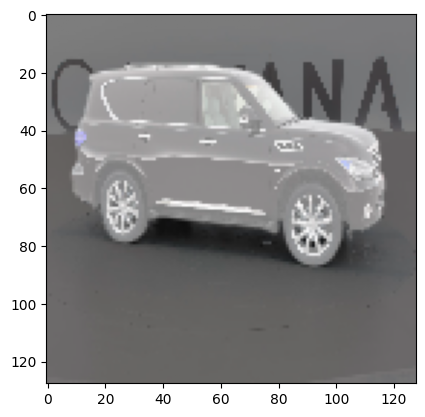

In [ ]:
# Чтобы оценить качество сегментации модели, мы отображаем сегментацию для пары валидационных изображений.
# Эти валидационные изображения оценивались в последнем тренировочном пакете.
# Заметьте, что модель не тренировалась на этих валидационных изображениях.

img = (out_x[1] > 0.5)*1.0
plt.imshow(grey2rgb(img), alpha=0.5)
plt.imshow(val_x[1])
plt.imshow(grey2rgb(val_y[1]), alpha=0.5)

In [ ]:
#  Проверяем наличие GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Запуск цикла обучения (с GPU)

with tf.Session() as sess:

    sess.run(init)
    for batch in range(600):

        with tf.device('/gpu:0'):
          batch_x, batch_y = next(train_gen)

        sess.run([optimizer], feed_dict={x:batch_x,y:batch_y})
        loss = sess.run([cost],feed_dict={x:batch_x,y:batch_y})

        with tf.device('/gpu:0'):
          val_x,val_y = next(validation_gen)

        loss_val = sess.run([cost],feed_dict={x:val_x,y:val_y})
        out_x = sess.run(logits,feed_dict={x:val_x})

        print('batch:', batch, 'train loss:', loss, 'validation loss:', loss_val)

batch: 0 train loss: [0.6979598] validation loss: [0.69795287]
batch: 1 train loss: [0.69790876] validation loss: [0.69796157]
batch: 2 train loss: [0.69775206] validation loss: [0.69799626]
batch: 3 train loss: [0.6978468] validation loss: [0.6977214]
batch: 4 train loss: [0.6979985] validation loss: [0.6978327]
batch: 5 train loss: [0.69762075] validation loss: [0.6979747]
batch: 6 train loss: [0.6976148] validation loss: [0.6975433]
batch: 7 train loss: [0.6976081] validation loss: [0.69759446]
batch: 8 train loss: [0.6973531] validation loss: [0.697671]
batch: 9 train loss: [0.6975622] validation loss: [0.69744575]
batch: 10 train loss: [0.6973762] validation loss: [0.6973946]
batch: 11 train loss: [0.69735765] validation loss: [0.6972267]
batch: 12 train loss: [0.69725585] validation loss: [0.6972091]
batch: 13 train loss: [0.6974223] validation loss: [0.6974741]
batch: 14 train loss: [0.69729626] validation loss: [0.69732714]
batch: 15 train loss: [0.6968352] validation loss: [0.

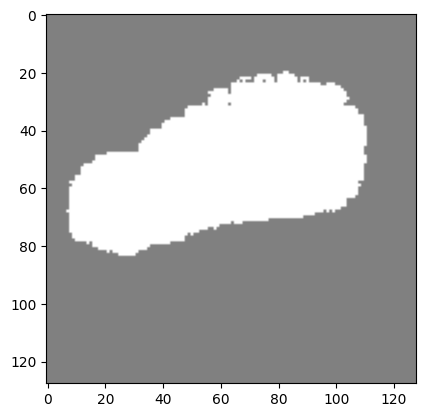

In [ ]:
# Чтобы оценить качество сегментации модели, мы отображаем сегментацию для пары валидационных изображений.
# Эти валидационные изображения оценивались в последнем тренировочном пакете.
# Заметьте, что модель не тренировалась на этих валидационных изображениях.
n = 18
img = (out_x[n] > 0.5)*1.0
plt.imshow(grey2rgb(img), alpha=0.5)

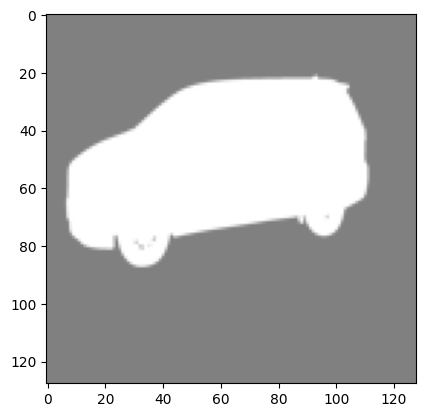

In [ ]:
plt.imshow(grey2rgb(val_y[n]), alpha=0.5)